# Data preprocess

In [1]:
import os
from math import floor 
from random import shuffle
import shutil

#Modify and Run this cell making new folders

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)
        

for i in range(14,63):
    createFolder('E:\\Datasets\\CACD\\train\\'+str(i))
    createFolder('E:\\Datasets\\CACD\\test\\'+str(i))

In [ ]:
root_dir = "D:\\Dataset\\Face dataset\\CACD2000"
list_dir = os.listdir(root_dir)


def get_train_test(data_list):
    split = 0.9
    index = floor(len(data_list)*split)
    training_data = data_list[:index]
    testing_data = data_list[index:]
    return training_data, testing_data

age_dit = {}

for j in range(14,63):
    ls = list()
    for i in range(0,len(list_dir)):
        if(j==int(list_dir[i][0:2])):
            ls.append(list_dir[i])
    age_dit[j]=ls
    ls.clear
    
for i in range(14,63):
    print(i)
    images_i =list(age_dit[i])
    shuffle(images_i)
    training_data, testing_data = get_train_test(images_i)
    for j in range(0,len(training_data)):
        src = root_dir+"\\"+training_data[j]
        des = 'E:\\Datasets\\CACD\\train\\'+str(i)
        shutil.copy(src,des)
    for j in range(0,len(testing_data)):
        src = root_dir+"\\"+training_data[j]
        des = 'E:\\Datasets\\CACD\\test\\'+str(i)
        shutil.copy(src,des)

# VGG-16 Model

In [3]:
import keras
import os, shutil
from keras import models, layers, losses, optimizers, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
%matplotlib inline

train_dir = 'E:\\Datasets\\CACD\\train'
test_dir = 'E:\\Datasets\\CACD\\test'

train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=15, 
                                   width_shift_range=0.1, 
                                   height_shift_range=0.1, 
                                   shear_range=0.1,
                                   zoom_range=0.15, 
                                   horizontal_flip=True
                                  )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir, 
    target_size=(150, 150), 
    batch_size=32
)

test_generator = test_datagen.flow_from_directory(
    test_dir, 
    target_size=(150, 150), 
    batch_size=32
)

C:\Users\bikas\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 147082 images belonging to 49 classes.
Found 16364 images belonging to 49 classes.


# Defining call back

In [4]:
class save_model_each_epoch(keras.callbacks.Callback):
    def __init__(self):
        self.predhis = []
    def on_epoch_end(self):
        model.save('model.h5')
        print("saved")

# Defining custom metrix

In [5]:
def five_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 5,
                  K.floatx())

def ten_claas_diff(y_true, y_pred):
    return K.cast(K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1)) <= 10,
                  K.floatx())


In [8]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150, 150, 3))
                 
                 
model = models.Sequential()

model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(49, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_4 (Dense)              (None, 49)                25137     
Total params: 18,934,641
Trainable params: 18,934,641
Non-trainable params: 0
_________________________________________________________________


In [10]:
conv_base.trainable = False
print('This is the number of trainable weights before freezing the conv base:', len(model.trainable_weights))

model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=4600, 
                              epochs=5, 
                              validation_data=test_generator,
                              callbacks=[keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)],
                              validation_steps=500)

This is the number of trainable weights before freezing the conv base: 4
Epoch 1/5
4600/4600 [==============================] - 814s 177ms/step - loss: 3.6880 - categorical_accuracy: 0.0399 - five_claas_diff: 0.3911 - ten_claas_diff: 0.6435 - val_loss: 3.6544 - val_categorical_accuracy: 0.0436 - val_five_claas_diff: 0.4058 - val_ten_claas_diff: 0.6500
Epoch 2/5
4600/4600 [==============================] - 803s 174ms/step - loss: 3.6655 - categorical_accuracy: 0.0440 - five_claas_diff: 0.4053 - ten_claas_diff: 0.6560 - val_loss: 3.6305 - val_categorical_accuracy: 0.0511 - val_five_claas_diff: 0.4294 - val_ten_claas_diff: 0.6827
Epoch 3/5
4600/4600 [==============================] - 874s 190ms/step - loss: 3.6534 - categorical_accuracy: 0.0450 - five_claas_diff: 0.4103 - ten_claas_diff: 0.6598 - val_loss: 3.6235 - val_categorical_accuracy: 0.0514 - val_five_claas_diff: 0.4326 - val_ten_claas_diff: 0.6801
Epoch 4/5
4600/4600 [==============================] - 805s 175ms/step - loss: 3.646

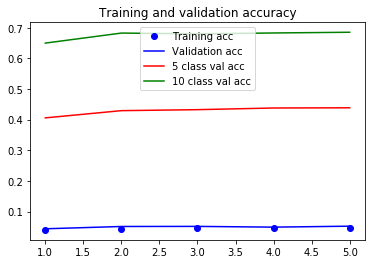

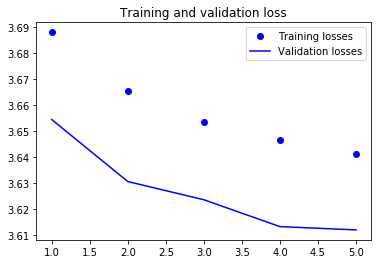

In [11]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
val_5_acc = history.history['val_five_claas_diff']
val_10_acc = history.history['val_ten_claas_diff']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_5_acc, 'r', label='5 class val acc')
plt.plot(epochs, val_10_acc, 'g', label='10 class val acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Fine tuning

In [ ]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(
    optimizer=optimizers.RMSprop(lr=1e-4), 
    loss=losses.categorical_crossentropy, 
    metrics=[metrics.categorical_accuracy, five_claas_diff, ten_claas_diff]
)

history = model.fit_generator(train_generator, 
                              steps_per_epoch=4600, 
                              epochs=30, 
                              validation_data=test_generator, 
                              callbacks=[
                                  keras.callbacks.ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1),
                                  keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto')
                              ],
                              validation_steps=500)

Epoch 1/30
4600/4600 [==============================] - 828s 180ms/step - loss: 3.6095 - categorical_accuracy: 0.0444 - five_claas_diff: 0.4413 - ten_claas_diff: 0.7002 - val_loss: 3.5596 - val_categorical_accuracy: 0.0499 - val_five_claas_diff: 0.4716 - val_ten_claas_diff: 0.7312
Epoch 2/30
4600/4600 [==============================] - 925s 201ms/step - loss: 3.5252 - categorical_accuracy: 0.0509 - five_claas_diff: 0.4923 - ten_claas_diff: 0.7554 - val_loss: 3.4762 - val_categorical_accuracy: 0.0554 - val_five_claas_diff: 0.5145 - val_ten_claas_diff: 0.7816
Epoch 3/30
4600/4600 [==============================] - 911s 198ms/step - loss: 3.4905 - categorical_accuracy: 0.0528 - five_claas_diff: 0.5119 - ten_claas_diff: 0.7750 - val_loss: 3.4474 - val_categorical_accuracy: 0.0544 - val_five_claas_diff: 0.5376 - val_ten_claas_diff: 0.8024
Epoch 4/30
4600/4600 [==============================] - 889s 193ms/step - loss: 3.4671 - categorical_accuracy: 0.0558 - five_claas_diff: 0.5273 - ten_claa

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
val_5_acc = history.history['val_five_claas_diff']
val_10_acc = history.history['val_ten_claas_diff']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.plot(epochs, val_5_acc, 'r', label='5 class val acc')
plt.plot(epochs, val_10_acc, 'g', label='10 class val acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training losses')
plt.plot(epochs, val_loss, 'b', label='Validation losses')
plt.title('Training and validation loss')
plt.legend()

plt.show()